## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Моисеенков И. П. |
|---------|--------|
| Группа  | М8О-308Б-19      |

Зафиксируем рандом стейт, чтобы результаты были воспроизводимые

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

random_state = 0xDEAD
np.random.seed(random_state)
torch.random.manual_seed(random_state)
torch.cuda.random.manual_seed_all(random_state);

Если есть возможность использовать гпу, то воспользуемся ей.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Теперь загружаем датасет. Для этого воспользуемся возможностями торча.

In [58]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
import torchvision.transforms as tfs

# сразу преобразуем данные в тензоры и выполним нормировку
data_tfs = tfs.Compose([
  tfs.ToTensor(),
  tfs.Normalize((0.5), (0.5))
])

root = './'
train = MNIST(root, train=True,  transform=data_tfs, download=True)
test  = MNIST(root, train=False, transform=data_tfs, download=True)

In [5]:
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [6]:
len(train), len(test)

(60000, 10000)

In [7]:
train[0][0].shape

torch.Size([1, 28, 28])

Сделаем даталоадеры.

In [8]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train, batch_size=batch_size, drop_last=True, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, drop_last=True)

# Обучение моделей

Функция для обучения модели

In [24]:
def train_model(model, train_loader, test_loader, epochs_num, optimizer, criterion, device):
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []

    for epoch in range(epochs_num):
        cur_train_acc = 0
        cur_test_acc = 0

        cur_train_loss = 0
        cur_test_loss = 0

        # training
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.view(X_batch.shape[0], -1).to(device)
            y_batch = y_batch.to(device)
            
            # forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            cur_train_loss += loss.item()

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # count metrics
            cur_train_acc += (y_batch.squeeze() == torch.argmax(y_pred, axis=1)).cpu().numpy().sum()
            
        # testing
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.view(X_batch.shape[0], -1).to(device)
                y_batch = y_batch.to(device)
                
                y_pred = model(X_batch)
                cur_test_acc += (y_batch.squeeze() == torch.argmax(y_pred, axis=1)).cpu().numpy().sum()

                loss = criterion(y_pred, y_batch)
                cur_test_loss += loss.cpu().item()

        
        train_acc_history.append(cur_train_acc / (len(train_loader) * batch_size))
        test_acc_history.append(cur_test_acc / (len(test_loader) * batch_size))
        train_loss_history.append(cur_train_loss / (len(train_loader) * batch_size))
        test_loss_history.append(cur_test_loss / (len(test_loader) * batch_size))
    
    return train_loss_history, test_loss_history, train_acc_history, test_acc_history

In [25]:
def plot_loss_history(train_loss_history, test_loss_history):
    plt.figure(figsize=(10, 8))
    plt.title("Loss")
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, linewidth=2, label='train loss')
    plt.plot(range(1, len(test_loss_history) + 1), test_loss_history, linewidth=2, label='test loss')
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [26]:
def plot_acc_history(train_acc_history, test_acc_history):
    plt.figure(figsize=(10, 8))
    plt.title("Accuracy")
    plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, linewidth=2, label='train accuracy')
    plt.plot(range(1, len(test_acc_history) + 1), test_acc_history, linewidth=2, label='test accuracy')
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

Функция для построения матрицы неточностей:

In [50]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(model, test_loader):
    preds = None
    reals = None
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.view(X_batch.shape[0], -1).to(device)
            y_batch = y_batch.to(device)
            
            y_pred = model(X_batch)
            if preds is None:
                preds = torch.argmax(y_pred, axis=1).cpu().numpy()
                reals = y_batch.cpu().numpy()
            else:
                preds = np.hstack([preds, torch.argmax(y_pred, axis=1).cpu().numpy()])
                reals = np.hstack([reals, y_batch.cpu().numpy()])

    print(confusion_matrix(reals, preds, labels=list(range(10))))

### Однослойный перцептрон

In [31]:
perceptron_1l = nn.Linear(28 * 28, 10).to(device)
criterion = nn.CrossEntropyLoss() # softmax уже включен сюда
optimizer = torch.optim.Adam(perceptron_1l.parameters(), lr=1e-3) # используем адам как один из лучших оптимайзеров

perceptron_1l_stats = train_model(perceptron_1l, train_loader, test_loader, 10, optimizer, criterion, device)

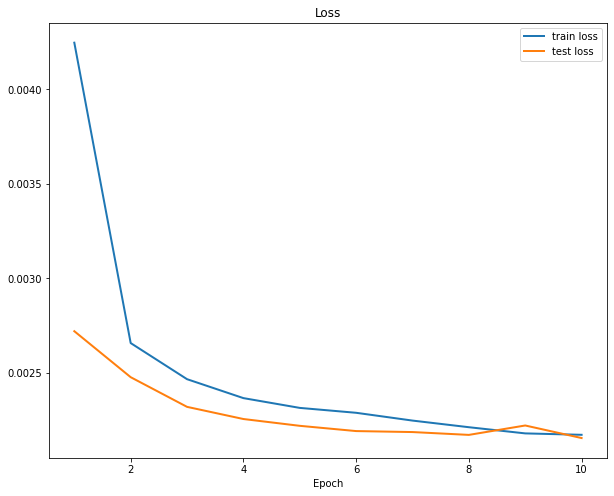

In [32]:
plot_loss_history(perceptron_1l_stats[0], perceptron_1l_stats[1])

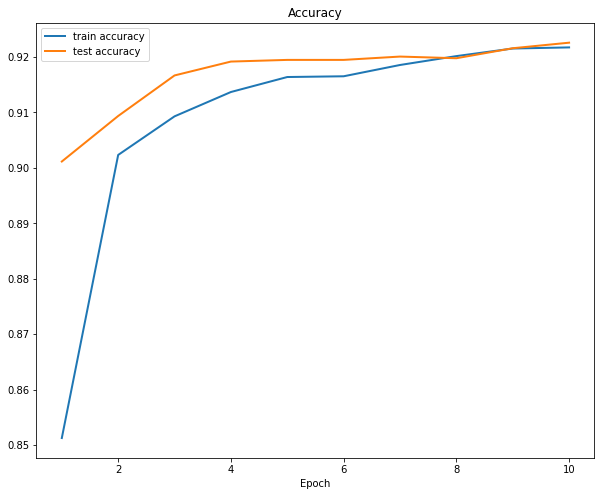

In [33]:
plot_acc_history(perceptron_1l_stats[2], perceptron_1l_stats[3])

In [34]:
print('Final accuracy =', perceptron_1l_stats[3][-1])

Final accuracy = 0.9225761217948718


In [51]:
print_confusion_matrix(perceptron_1l, test_loader)

[[ 959    0    2    1    0    4   10    2    1    0]
 [   0 1111    2    2    0    1    4    2   11    0]
 [   7   11  937   11   11    3   13    8   23    6]
 [   5    2   25  900    0   35    4   11   16   10]
 [   1    3    6    1  917    0   10    3    7   32]
 [  10    3    4   26   10  780   21    5   25    6]
 [  10    3    5    1   10    9  914    2    2    0]
 [   3   14   23    5   10    1    0  937    2   32]
 [   8   14    7   21   10   31   12   10  852    8]
 [   9    8    1    8   36    6    1   25   10  904]]


### Многослойный перцептрон

Будем использовать релу как наиболее популярную функцию для обучения нейросетей.

In [52]:
perceptron_2l = nn.Sequential(
    nn.Linear(28 * 28, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(perceptron_2l.parameters(), lr=1e-3) # используем адам как один из лучших оптимайзеров

perceptron_2l_stats = train_model(perceptron_2l, train_loader, test_loader, 10, optimizer, criterion, device)

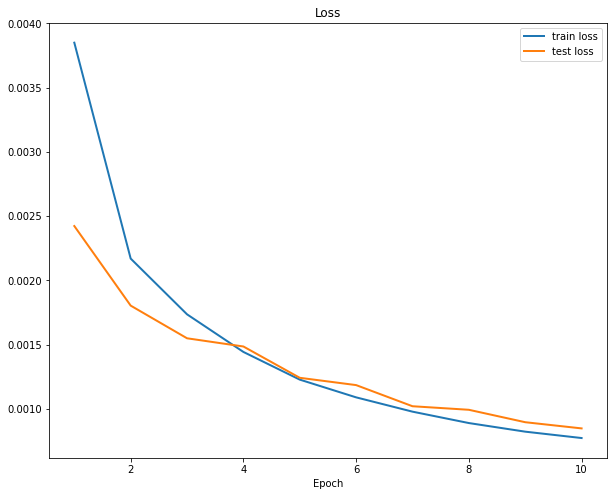

In [53]:
plot_loss_history(perceptron_2l_stats[0], perceptron_2l_stats[1])

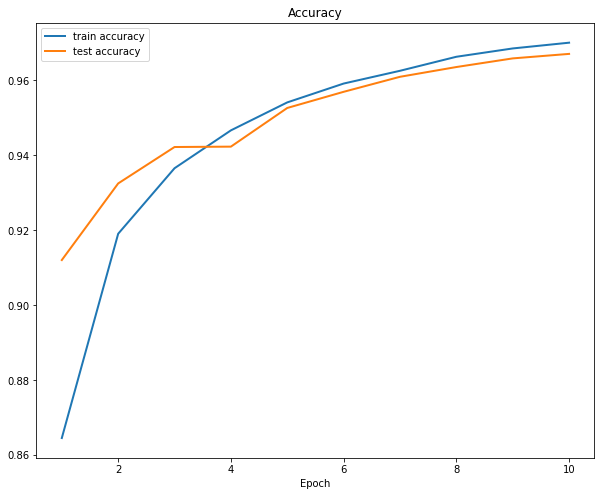

In [54]:
plot_acc_history(perceptron_2l_stats[2], perceptron_2l_stats[3])

In [55]:
print('Final accuracy =', perceptron_2l_stats[3][-1])

Final accuracy = 0.9670472756410257


In [56]:
print_confusion_matrix(perceptron_2l, test_loader)

[[ 967    0    0    0    0    5    1    2    2    2]
 [   0 1123    2    2    0    1    1    1    3    0]
 [   8    2  981    8    4    1    5   10   11    0]
 [   0    0    5  978    1   11    0    7    5    1]
 [   0    0    2    1  943    2    4    5    1   22]
 [   5    1    1   15    3  848    6    2    7    2]
 [   7    3    1    0    8    6  926    2    3    0]
 [   0    4    6    8    0    0    0  997    0   12]
 [   7    1    3   10    5    7    6    6  922    6]
 [   6    3    1    4    9    3    0    8    4  970]]


Получили точность 96,7% на двуслойном перцептроне.

Параметры обучения:
* 2 линейных слоя. Промежуточный имеет размерность 64. 
* 10 эпох
* batch_size = 128
* optimizer = Adam, lr = 1e-3
* loss = cross entropy

По сравнению с аналогичным перцептроном, реализованным мной, мы получили значительное увеличение точности. Это произошло по следующим причинам:
* Здесь мы использовали более продвинутый алгоритм обучения - адам, который адаптивно подбирает lr на каждом шаге и накапливает "импульс" с предыдущих итераций. Это помогает ему быстрее и точнее двигаться к минимуму функции.

* Здесь мы применили нормировку данных. Нейросеть лучше обрабатывает нормированные признаки.

# Fashion MNIST

Обучим классификатор на датасете с черно-белой одеждой.

Загрузим датасет

In [60]:
train_fashion = FashionMNIST(root, train=True,  transform=data_tfs, download=True)
test_fashion  = FashionMNIST(root, train=False, transform=data_tfs, download=True)

In [61]:
len(train_fashion), len(test_fashion)

(60000, 10000)

In [63]:
train_fashion[0][0].shape

torch.Size([1, 28, 28])

In [64]:
train_loader_fashion = DataLoader(train_fashion, batch_size=batch_size, drop_last=True, shuffle=True)
test_loader_fashion = DataLoader(test_fashion, batch_size=batch_size, drop_last=True)

### Однослойный перцептрон

In [66]:
perceptron_1l_fashion = nn.Linear(28 * 28, 10).to(device)
criterion = nn.CrossEntropyLoss() # softmax уже включен сюда
optimizer = torch.optim.Adam(perceptron_1l_fashion.parameters(), lr=1e-3) # используем адам как один из лучших оптимайзеров

perceptron_1l_stats_fashion = train_model(perceptron_1l_fashion, train_loader_fashion, test_loader_fashion, 10, optimizer, criterion, device)

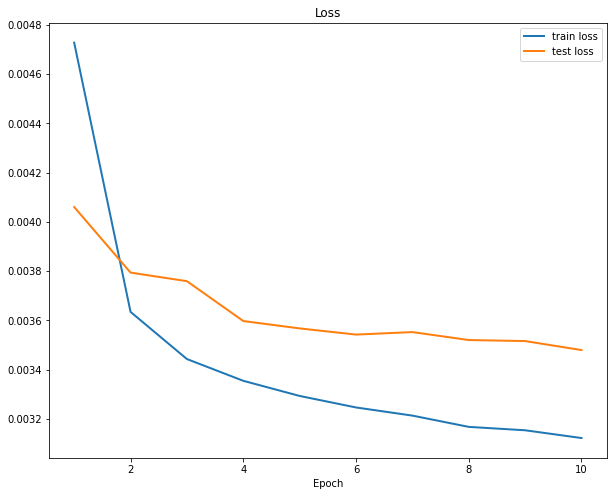

In [67]:
plot_loss_history(perceptron_1l_stats_fashion[0], perceptron_1l_stats_fashion[1])

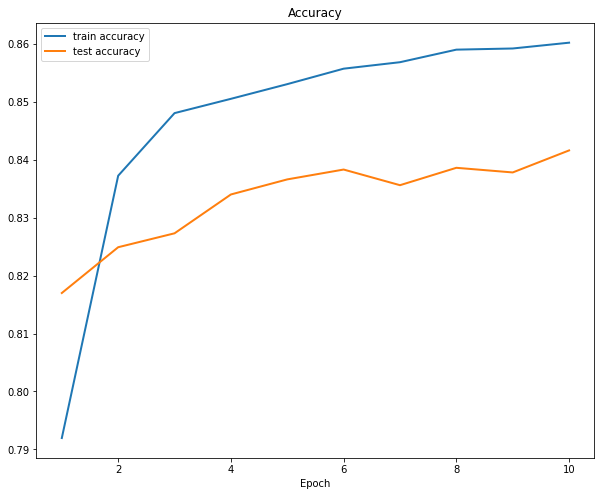

In [68]:
plot_acc_history(perceptron_1l_stats_fashion[2], perceptron_1l_stats_fashion[3])

In [69]:
print('Final accuracy =', perceptron_1l_stats_fashion[3][-1])

Final accuracy = 0.8416466346153846


In [70]:
print_confusion_matrix(perceptron_1l_fashion, test_loader_fashion)

[[845   0  10  37   6   4  90   0   8   0]
 [  4 953   2  29   6   0   2   0   1   0]
 [ 32   3 685  12 154   1 102   0  10   0]
 [ 46   8  12 854  27   0  48   0   4   0]
 [  0   1  80  37 782   1  90   0   8   0]
 [  1   0   0   1   0 919   0  57   4  15]
 [155   1 107  31 112   3 566   0  24   0]
 [  0   0   0   0   0  31   0 949   0  19]
 [  7   1   8  13   2  10  21   7 928   0]
 [  0   0   0   0   0  22   0  53   1 922]]


Уже на однослойном перцептроне мы смогли получить точность 84%. Хороший результат

### Двуслойный перцептрон

In [71]:
perceptron_2l_fashion = nn.Sequential(
    nn.Linear(28 * 28, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(perceptron_2l_fashion.parameters(), lr=1e-3) # используем адам как один из лучших оптимайзеров

perceptron_2l_stats_fashion = train_model(perceptron_2l_fashion, train_loader_fashion, test_loader_fashion, 10, optimizer, criterion, device)

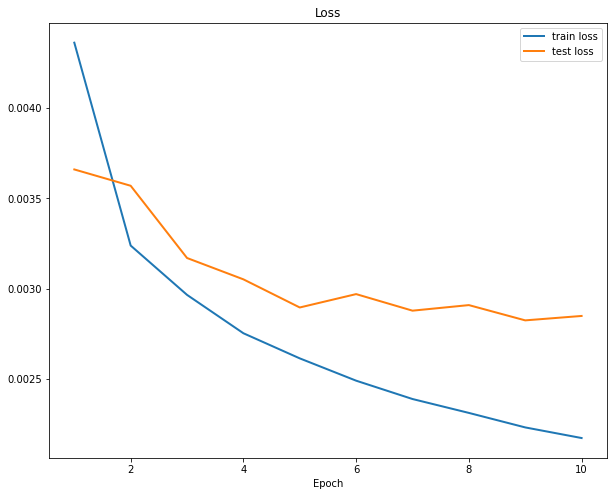

In [72]:
plot_loss_history(perceptron_2l_stats_fashion[0], perceptron_2l_stats_fashion[1])

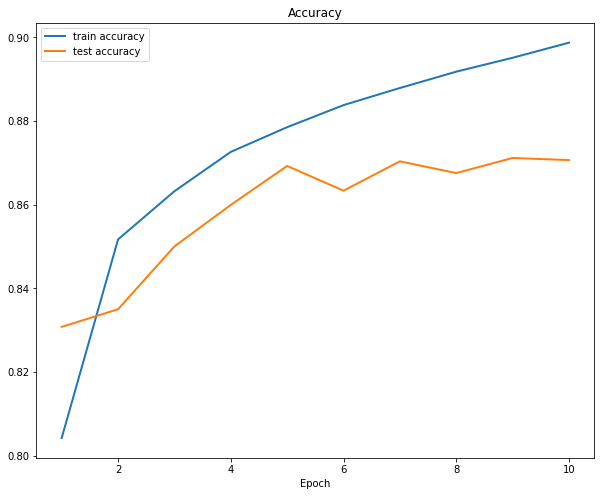

In [73]:
plot_acc_history(perceptron_2l_stats_fashion[2], perceptron_2l_stats_fashion[3])

In [74]:
print('Final accuracy =', perceptron_2l_stats_fashion[3][-1])

Final accuracy = 0.8706931089743589


In [75]:
print_confusion_matrix(perceptron_2l_fashion, test_loader_fashion)

[[756   2  17  79   2   1 136   0   7   0]
 [  0 966   0  25   3   0   2   0   1   0]
 [ 10   0 836  24  67   1  60   0   1   0]
 [ 13  11   8 935  10   0  19   0   3   0]
 [  0   1 121  57 775   0  45   0   0   0]
 [  0   0   0   1   0 946   0  31   1  18]
 [ 91   0 112  61  85   0 640   0  10   0]
 [  0   0   0   0   0  27   0 959   0  13]
 [  6   1  10  10   4   5  11   4 946   0]
 [  1   0   0   0   0   8   0  55   0 934]]


Точность поднялась до 87%. Больше эпох обучать не вижу смысла, так как скорее будет переобучение. Тестовый лосс уже перестал снижаться.

### Трехслойный перцептрон
Ради интереса попробуем использовать трехслойную полносвязную сеть.

In [76]:
perceptron_3l_fashion = nn.Sequential(
    nn.Linear(28 * 28, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(perceptron_3l_fashion.parameters(), lr=1e-3) # используем адам как один из лучших оптимайзеров

perceptron_3l_stats_fashion = train_model(perceptron_3l_fashion, train_loader_fashion, test_loader_fashion, 10, optimizer, criterion, device)

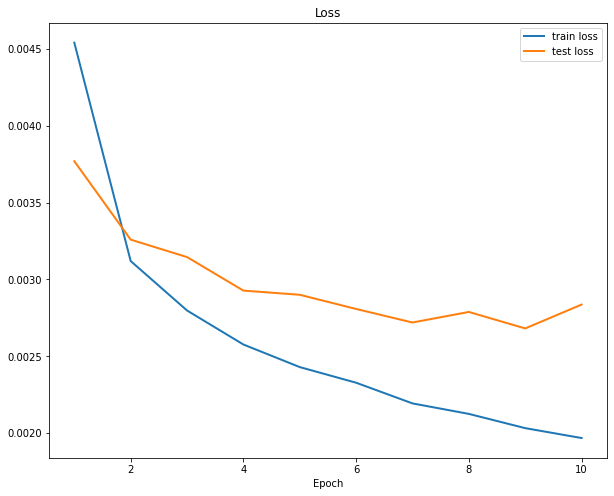

In [77]:
plot_loss_history(perceptron_3l_stats_fashion[0], perceptron_3l_stats_fashion[1])

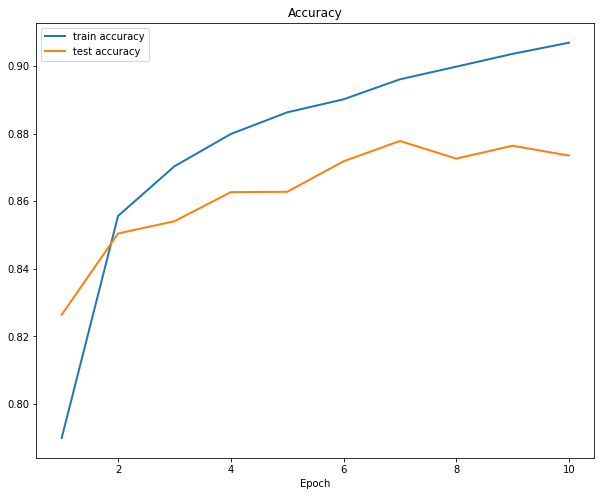

In [78]:
plot_acc_history(perceptron_3l_stats_fashion[2], perceptron_3l_stats_fashion[3])

In [79]:
print('Final accuracy =', perceptron_3l_stats_fashion[3][-1])

Final accuracy = 0.8734975961538461


In [80]:
print_confusion_matrix(perceptron_3l_fashion, test_loader_fashion)

[[839   2  13  22   3   0 111   1   9   0]
 [  2 971   1  15   4   0   2   0   2   0]
 [ 15   0 781  15 113   0  73   0   2   0]
 [ 28  13  10 880  28   0  32   0   8   0]
 [  1   1  65  32 840   0  58   0   2   0]
 [  0   0   0   0   0 843   0 118   2  34]
 [123   2  79  21  77   0 682   0  15   0]
 [  0   0   0   0   0   3   0 981   0  15]
 [  6   0   0   4   3   1   6   7 970   0]
 [  0   0   0   0   0   4   1  59   0 934]]


Снова видим, что увеличение эпох ничего не даст из-за начала переобучения.

Тем не менее, мы получили точность 87%, что является хорошим результатом.

# CIFAR 10

Попробуем обучить классификатор цветных картинок с цифрами.

In [82]:
train_cifar = CIFAR10(root, train=True,  transform=data_tfs, download=True)
test_cifar = CIFAR10(root, train=False, transform=data_tfs, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [83]:
len(train_cifar), len(test_cifar)

(50000, 10000)

In [84]:
train_cifar[0][0].shape

torch.Size([3, 32, 32])

Картинки цветные, поэтому у нас вместо одного канала (чб) теперь три канала (RGB).

Будем все "расплющивать" в один вектор. Хотя в качестве альтернативы можно было попробовать использовать средние значения трех каналов и тем самым сократить входной размер в 3 раза.

In [85]:
train_loader_cifar = DataLoader(train_cifar, batch_size=batch_size, drop_last=True, shuffle=True)
test_loader_cifar = DataLoader(test_cifar, batch_size=batch_size, drop_last=True)

### Однослойный перцептрон

In [87]:
perceptron_1l_cifar = nn.Linear(3 * 32 * 32, 10).to(device)
criterion = nn.CrossEntropyLoss() # softmax уже включен сюда
optimizer = torch.optim.Adam(perceptron_1l_cifar.parameters(), lr=1e-3) # используем адам как один из лучших оптимайзеров

perceptron_1l_stats_cifar = train_model(perceptron_1l_cifar, train_loader_cifar, test_loader_cifar, 10, optimizer, criterion, device)

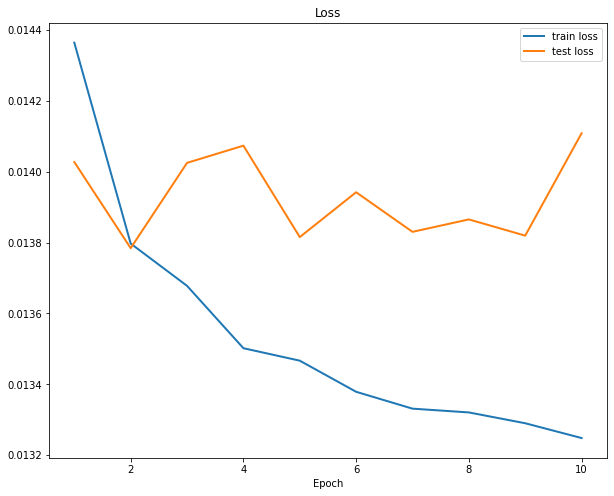

In [88]:
plot_loss_history(perceptron_1l_stats_cifar[0], perceptron_1l_stats_cifar[1])

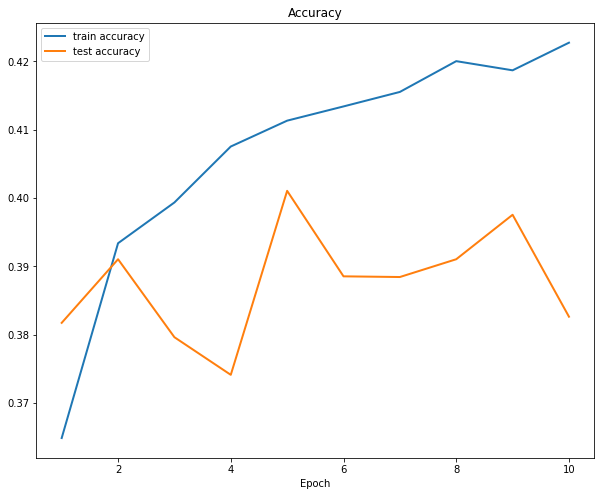

In [89]:
plot_acc_history(perceptron_1l_stats_cifar[2], perceptron_1l_stats_cifar[3])

In [90]:
print('Final accuracy =', perceptron_1l_stats_cifar[3][-1])

Final accuracy = 0.38261217948717946


In [91]:
print_confusion_matrix(perceptron_1l_cifar, test_loader_cifar)

[[467  38  42  33  29  72  20  48 181  68]
 [ 67 450  16  73  24  27  29  44  89 180]
 [104  35 251 145 107  81 120  64  60  32]
 [ 42  49  75 321  59 173  95  44  59  80]
 [ 59  23 133 142 280  71 127  94  39  32]
 [ 47  40 105 232  77 262  63  66  74  31]
 [ 17  37  68 246  94  62 376  33  29  38]
 [ 65  37  49 104  95  81  30 417  47  72]
 [169  53  16  42  12  38   9  15 526 117]
 [ 91 153  16  45  14  24  31  44 112 470]]


Пока что фигня. Модель вообще почти не обучилась. Попробуем усложнить архитектуру и добавить еще один слой.

### Двуслойный перцептрон

In [92]:
perceptron_2l_cifar = nn.Sequential(
    nn.Linear(3 * 32 * 32, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(perceptron_2l_cifar.parameters(), lr=1e-3) # используем адам как один из лучших оптимайзеров

perceptron_2l_stats_cifar = train_model(perceptron_2l_cifar, train_loader_cifar, test_loader_cifar, 10, optimizer, criterion, device)

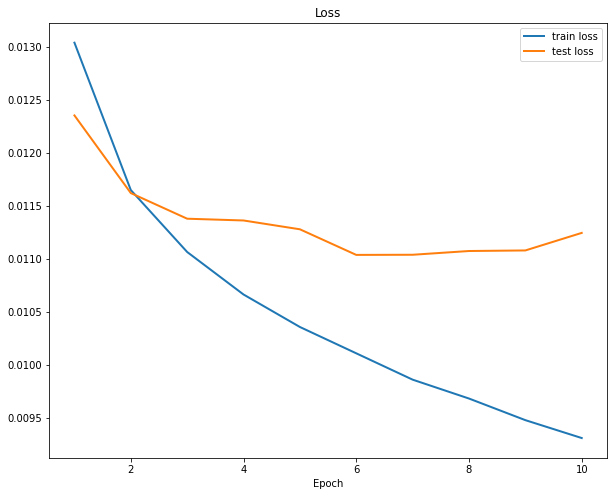

In [93]:
plot_loss_history(perceptron_2l_stats_cifar[0], perceptron_2l_stats_cifar[1])

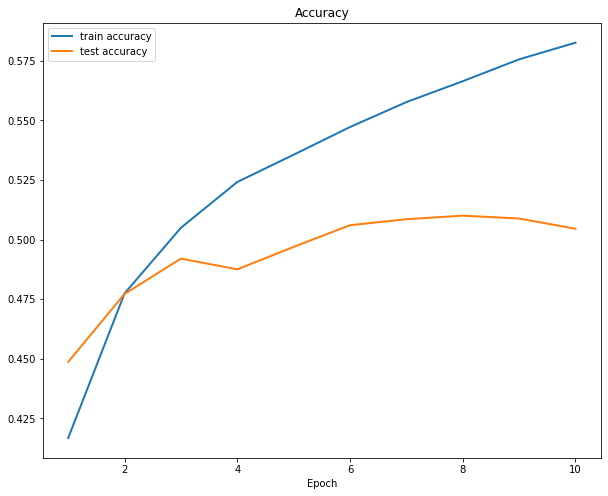

In [94]:
plot_acc_history(perceptron_2l_stats_cifar[2], perceptron_2l_stats_cifar[3])

In [95]:
print('Final accuracy =', perceptron_2l_stats_cifar[3][-1])

Final accuracy = 0.5045072115384616


In [96]:
print_confusion_matrix(perceptron_2l_cifar, test_loader_cifar)

[[534  39  73  11  31  25  27  37 165  56]
 [ 31 555  24  20  13  21  35  33  94 173]
 [ 65  11 379  65 117 113 110  85  26  28]
 [ 22  21  65 273  47 270 136  71  39  53]
 [ 41   7 116  56 361  72 163 132  35  17]
 [ 21   7  75 139  56 458  87  91  27  36]
 [  8  24  62  68  62  61 641  25  26  23]
 [ 38  11  42  37  62 100  42 592  20  53]
 [ 82  51  16  17  23  28   9  16 688  67]
 [ 35 170  21  21  15  31  23  40  88 556]]


Уже лучше - 50%. Попробуем еще один слой.

### Трехслойный перцептрон

In [97]:
perceptron_3l_cifar = nn.Sequential(
    nn.Linear(3 * 32 * 32, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(perceptron_3l_cifar.parameters(), lr=1e-3) # используем адам как один из лучших оптимайзеров

perceptron_3l_stats_cifar = train_model(perceptron_3l_cifar, train_loader_cifar, test_loader_cifar, 10, optimizer, criterion, device)

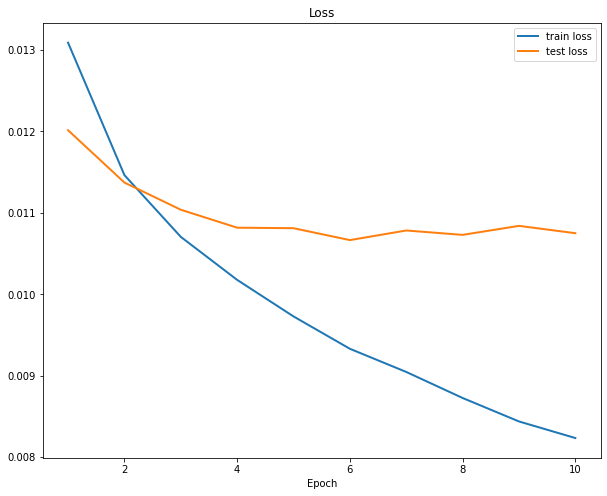

In [98]:
plot_loss_history(perceptron_3l_stats_cifar[0], perceptron_3l_stats_cifar[1])

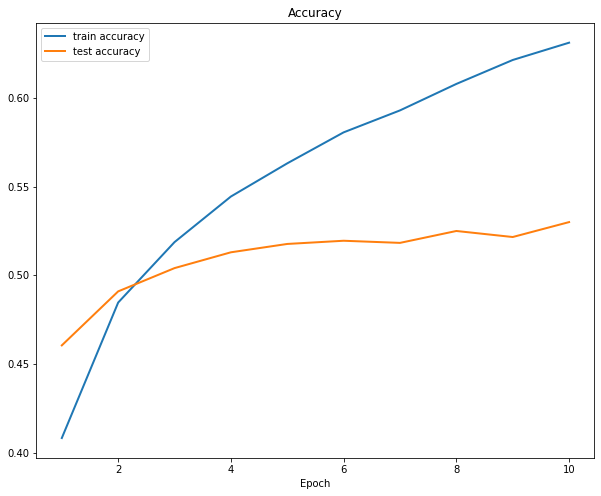

In [99]:
plot_acc_history(perceptron_3l_stats_cifar[2], perceptron_3l_stats_cifar[3])

In [100]:
print('Final accuracy =', perceptron_3l_stats_cifar[3][-1])

Final accuracy = 0.5299479166666666


In [101]:
print_confusion_matrix(perceptron_3l_cifar, test_loader_cifar)

[[584  27  57  19  25  14  25  25 157  65]
 [ 32 620  15  26   5  10  13  28  93 157]
 [ 84  12 426  66  90 104 100  77  27  13]
 [ 37  20 101 278  43 235 130  66  37  50]
 [ 55  14 167  52 366  60 124 116  28  18]
 [ 19  18  80 158  40 483  70  69  30  30]
 [  6  19  81  64  68  83 621  23  18  17]
 [ 42  11  59  46  40  89  34 604  21  51]
 [ 82  65  17  15  14  18   8   4 711  63]
 [ 39 155  21  28   5  21  25  32  76 598]]


Ожидаемо, мы не получили высокую точность с помощью перцептронов. Цветные картинки слишком сложные для линейных моделей. Здесь следует применять более продвинутые техники - сверточные сети. Тогда мы с большей вероятностью получим хороший результат